In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [150]:
df = pd.read_csv('POP.csv')
df

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.000,1952-01-01,2019-12-06
1,2019-12-06,156527.000,1952-02-01,2019-12-06
2,2019-12-06,156731.000,1952-03-01,2019-12-06
3,2019-12-06,156943.000,1952-04-01,2019-12-06
4,2019-12-06,157140.000,1952-05-01,2019-12-06
...,...,...,...,...
811,2019-12-06,329591.333,2019-08-01,2019-12-06
812,2019-12-06,329785.872,2019-09-01,2019-12-06
813,2019-12-06,329982.035,2019-10-01,2019-12-06
814,2019-12-06,330154.949,2019-11-01,2019-12-06


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   realtime_start  816 non-null    object 
 1   value           816 non-null    float64
 2   date            816 non-null    object 
 3   realtime_end    816 non-null    object 
dtypes: float64(1), object(3)
memory usage: 25.6+ KB


In [152]:
df.nunique()

realtime_start      1
value             816
date              816
realtime_end        1
dtype: int64

- realtime_start and realtime_end columns are not give useful information. It will be dropped.
- The date column still have wrong dtype.
- I change the name of value column to population

In [153]:
#Drop columns
df.drop(['realtime_start','realtime_end'], axis=1,inplace=True)

In [154]:
#Change column's type
df['date'].astype('datetime64')

0     1952-01-01
1     1952-02-01
2     1952-03-01
3     1952-04-01
4     1952-05-01
         ...    
811   2019-08-01
812   2019-09-01
813   2019-10-01
814   2019-11-01
815   2019-12-01
Name: date, Length: 816, dtype: datetime64[ns]

In [155]:
#change column's name
df.rename(columns={'value':'population'},inplace=True)

In [156]:
#set date as df index
df.set_index('date',inplace=True)

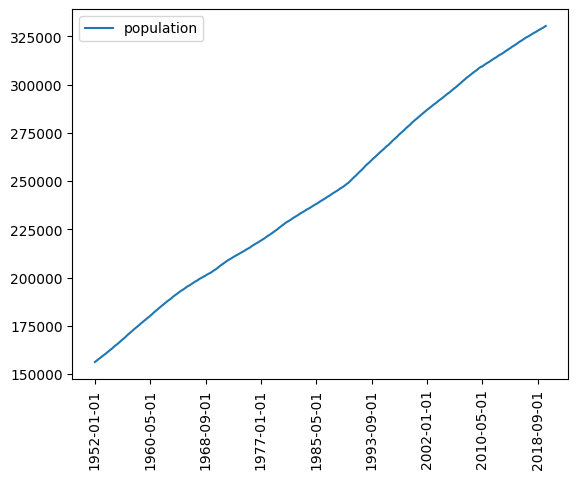

In [157]:
# create line plot
ax = df.plot()
ax.tick_params('x', labelrotation=90)
ax.set_xlabel('')
plt.show()


In [158]:
#Splitting the train and test set (~90%)
train_df = df[0:12*61] 
test_df = df[12*61:]

In [159]:
test_df.head()

,population
date,
2013-01-01,315389.595
2013-02-01,315520.143
2013-03-01,315662.224
2013-04-01,315817.855
2013-05-01,315983.654


In [160]:
#Standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scale = scaler.fit_transform(train_df)
test_scale = scaler.transform(test_df)

In [161]:
import torch

#change to tensor and flatten
train_tensor = torch.FloatTensor(train_scale).view(-1)
test_tensor = torch.FloatTensor(test_scale).view(-1)

In [162]:
train_tensor

tensor([-1.7380e+00, -1.7332e+00, -1.7287e+00, -1.7240e+00, -1.7196e+00,
        -1.7151e+00, -1.7105e+00, -1.7051e+00, -1.6994e+00, -1.6938e+00,
        -1.6906e+00, -1.6838e+00, -1.6790e+00, -1.6747e+00, -1.6707e+00,
        -1.6661e+00, -1.6619e+00, -1.6573e+00, -1.6522e+00, -1.6463e+00,
        -1.6404e+00, -1.6346e+00, -1.6292e+00, -1.6241e+00, -1.6188e+00,
        -1.6139e+00, -1.6092e+00, -1.6042e+00, -1.5995e+00, -1.5945e+00,
        -1.5892e+00, -1.5834e+00, -1.5772e+00, -1.5711e+00, -1.5653e+00,
        -1.5599e+00, -1.5546e+00, -1.5497e+00, -1.5451e+00, -1.5399e+00,
        -1.5352e+00, -1.5301e+00, -1.5249e+00, -1.5191e+00, -1.5129e+00,
        -1.5066e+00, -1.5007e+00, -1.4952e+00, -1.4898e+00, -1.4847e+00,
        -1.4796e+00, -1.4741e+00, -1.4694e+00, -1.4644e+00, -1.4590e+00,
        -1.4527e+00, -1.4461e+00, -1.4396e+00, -1.4333e+00, -1.4278e+00,
        -1.4221e+00, -1.4169e+00, -1.4119e+00, -1.4066e+00, -1.4015e+00,
        -1.3962e+00, -1.3908e+00, -1.3847e+00, -1.3

In [163]:
# function for making sequential data
def input_data(data, seq_size):
    out = []
    length = len(data)
    
    for i in range(length-seq_size):
        feature = data[i : i+seq_size]
        target = data[i+seq_size : i+seq_size+1]
        out.append((feature, target))
    
    return out

In [164]:
train_dataset = input_data(train_tensor, 12)
test_dataset = input_data(test_tensor, 12)

In [165]:
from torch.utils.data import DataLoader

# setting batch size
bs = 9

#make the dataloader
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [166]:
#make the architecture

from torch import nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers
        ) # RNN block
        self.fc = nn.Linear(
            in_features = hidden_size,
            out_features = output_size
        ) # fully connected layer
        
    def forward(self, x, hidden): #feedforward step
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        
        return x, hidden

In [168]:
config = {
    "input_size": 12, 
    "output_size": 1, 
    "hidden_size": 64, 
    "num_layers": 2
}

In [169]:
torch.manual_seed(2102)

model = RNN(
    input_size = config["input_size"], 
    output_size = config["output_size"], 
    hidden_size = config["hidden_size"], 
    num_layers = config["num_layers"]
)

In [170]:
#MSE loss function
criterion = nn.MSELoss()

In [172]:
from torch import optim

optimizer = optim.SGD(params = model.parameters(), lr = 0.002)
model.parameters

<bound method Module.parameters of RNN(
  (rnn): RNN(12, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)>

In [173]:
device = "gpu" if torch.cuda.is_available() else "cpu"

In [175]:
epochs = 100
train_cost, test_cost = [], []

for i in range(epochs):
    # training
    model.train()
    cost = 0
    for feature, target in train_loader: # iteration for minibatch
        # feedforward
        output, hidden = model.forward(feature, None)
        # loss
        loss = criterion(output, target)
        # backpropagation
        loss.backward()
        # update weight
        optimizer.step()
        # reset optimizer 
        optimizer.zero_grad()
        
        # total loss per minibatch 
        cost += loss.item() * feature.shape[0] 
    train_cost.append(cost / len(train_dataset)) # cost (MSE) per epoch 
    
    #Evaluation
    with torch.no_grad(): 
        model.eval()
        cost = 0
        for feature, target in test_loader:
            # feedforward
            output, hidden = model.forward(feature, None)
            # loss
            loss = criterion(output, target)
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_dataset)) # cost (MSE) per epoch 

    print(f'\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f}', end=' ')

Epoch: 100/100 | train_cost: 0.000607 | test_cost: 0.009954 

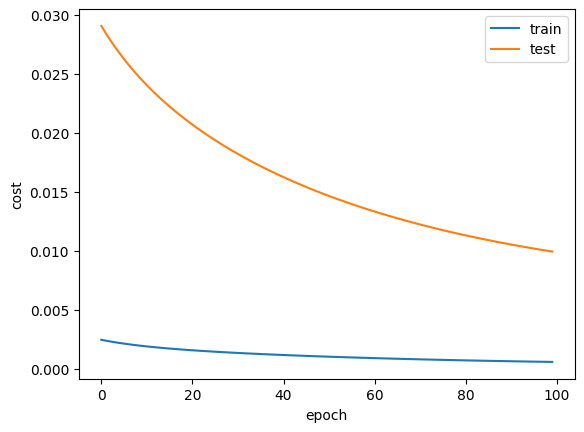

In [176]:
plt.plot(train_cost, label = "train")
plt.plot(test_cost, label = "test")

plt.xlabel("epoch")
plt.ylabel("cost")
plt.legend()

In [177]:
preds, targets = [], []
hidden = None
last_inputs = None

month = 120 # jumlah bulan yang akan diprediksi

with torch.no_grad():
    model.eval() 
    for inputs, target in test_loader: 
        output, hidden = model(inputs, hidden)
        preds += output.flatten().tolist()
        targets += target.flatten().tolist()
        last_inputs = inputs

    n_forecast = int(np.ceil(month/len(last_inputs))) # karena menggunakan minibatch, maka jumlah iterasi menyesuaikan

    for i in range(int(n_forecast)):
        # take last prediction result for new input
        pred_inputs = (last_inputs[-1][1:]).tolist()
        pred_inputs.append(preds[-1])
        
        # create new input format for models
        forecast_inputs = last_inputs[1:].tolist()
        forecast_inputs.append(pred_inputs)
        forecast_inputs = torch.tensor(forecast_inputs)
        
        # forecast and saving the result
        output, hidden = model(forecast_inputs, hidden)
        last_inputs = forecast_inputs
        preds += output.flatten().tolist()

# inverse the result since we use scaling on our data
preds = scaler.inverse_transform(pd.DataFrame(preds))
targets = scaler.inverse_transform(pd.DataFrame(targets))

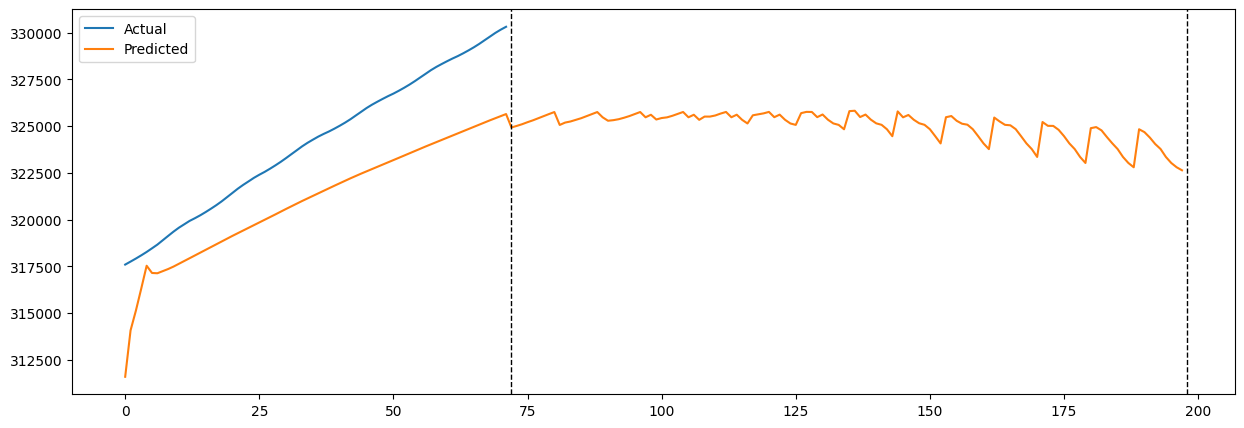

In [178]:
# Plot the predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(targets, label='Actual')
plt.plot(preds, label='Predicted')

plt.axvline(len(test_dataset), color='k', linestyle="--", linewidth=1)
plt.axvline(len(test_dataset) + n_forecast*len(last_inputs), color='k', linestyle="--", linewidth=1)

plt.legend()
plt.show()